In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)


class MnistDataSet(torch.utils.data.Dataset):
    def __init__(self):
        mnist_train = datasets.MNIST(root='./mnist_data/', train=True, download=True)
        self.data = mnist_train.data.reshape(-1, 784).float() / 255.0

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = MnistDataSet()

Wed Jan 13 14:51:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
def rp(mu, lv):
    return mu + torch.exp(0.5 * lv) * torch.randn_like(mu)

def KLD_normals(mu1, lv1, mu2, lv2):
    kld = lv2 - lv1 + (torch.exp(lv1) + ((mu1 - mu2)**2))/torch.exp(lv2) - 1.0
    return 0.5 * kld

def RATE_normals(mu, lv):
    kld = - lv + torch.exp(lv) + (mu**2) - 1.0
    return 0.5 * kld

class Draw(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.LSTMCell(784 * 2 + 400, 400)
        self.z_inf = nn.Linear(400, 100 * 2)
        self.dec = nn.LSTMCell(100, 400)
        self.w = nn.Linear(400, 784)




    def forward(self, x, T):
        nb, _ = x.size()
        h_enc = torch.zeros((nb, 400), requires_grad=True).to(device)
        c_enc = torch.zeros((nb, 400), requires_grad=True).to(device)
        h_dec = torch.zeros((nb, 400), requires_grad=True).to(device)
        c_dec = torch.zeros((nb, 400), requires_grad=True).to(device)
        canvas_curr = torch.zeros_like(x)
        canvas_seq = [canvas_curr]
        z_params = []
        for t in range(1, T):
            canvas_prev = canvas_seq[-1]
            x_hat = x - torch.sigmoid(canvas_prev)
            r_t = self.read(x, x_hat)
            h_enc, c_enc = self.enc(torch.cat([r_t, h_dec], dim=1), (h_enc, c_enc))
            mu, lv = self.z_inf(h_enc).chunk(2, dim=1)
            z_params.append({'mu':mu, 'lv':lv})
            z = rp(mu, lv)
            h_dec, c_dec = self.dec(z, (h_dec, c_dec))
            canvas_curr = canvas_prev + self.write(h_dec)
            canvas_seq.append(canvas_curr)
        
        return torch.sigmoid(canvas_curr) , z_params


    def reconstruction_history(self, x, T):
        nb, _ = x.size()
        h_enc = torch.zeros((nb, 400), requires_grad=True).to(device)
        c_enc = torch.zeros((nb, 400), requires_grad=True).to(device)
        h_dec = torch.zeros((nb, 400), requires_grad=True).to(device)
        c_dec = torch.zeros((nb, 400), requires_grad=True).to(device)
        canvas_curr = torch.zeros_like(x)
        canvas_seq = [canvas_curr]

        for t in range(1, T):
            canvas_prev = canvas_seq[-1]
            x_hat = x - torch.sigmoid(canvas_prev)
            r_t = self.read(x, x_hat)
            h_enc, c_enc = self.enc(torch.cat([r_t, h_dec], dim=1), (h_enc, c_enc))
            mu, lv = self.z_inf(h_enc).chunk(2, dim=1)
            z = rp(mu, lv)
            h_dec, c_dec = self.dec(z, (h_dec, c_dec))
            canvas_curr = canvas_prev + self.write(h_dec)
            canvas_seq.append(canvas_curr)
        
        history = []
        for canv in canvas_seq:
            history.append(torch.sigmoid(canv.detach()))
        return history


    def read(self, x, x_hat):
        return torch.cat([x, x_hat], dim=1)

    def write(self, h_dec):
        return self.w(h_dec)





In [28]:
mbsz = 32
model = Draw().to(device)
solver = optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(dataset=dataset, batch_size=mbsz, shuffle=True, drop_last=True)

In [29]:
num_epochs = 10
for epoch in range(num_epochs):
    RECON = 0.0
    KLD = 0.0

    for x_q in loader:
        solver.zero_grad()
        x_q = x_q.to(device).float()
        x_p, z_params = model(x_q, 16)
        
        recon = F.binary_cross_entropy(x_p, x_q, reduction='mean') * 784
        kld = 0
        for z_par in z_params:
            kld += RATE_normals(z_par['mu'], z_par['lv']).mean() * 100
        
        loss = recon + kld

        loss.backward()
        solver.step() 
 
        RECON += recon.item()
        KLD += kld.item()
    RECON /= (len(loader) * 784)
    KLD /= (len(loader) * 100)

    print(epoch, 'recon:', RECON, 'kld', KLD)

0 recon: 0.18934553681457936 kld 0.13840230530293782
1 recon: 0.12965407666057147 kld 0.2102861320699056
2 recon: 0.11687555613096068 kld 0.2317001371561686
3 recon: 0.11115715872316945 kld 0.23806960972086588
4 recon: 0.10766386568757141 kld 0.23927281196085612
5 recon: 0.10527408482039056 kld 0.24067326811726888
6 recon: 0.10344676350703856 kld 0.240311180074056
7 recon: 0.10197593766296802 kld 0.23992839475504557
8 recon: 0.10076291931567549 kld 0.2396726903483073
9 recon: 0.09970828021302515 kld 0.23897339389038086


In [8]:
testdataset = datasets.MNIST(root='./mnist_data/', train=False, download=True).data.float() / 255.0

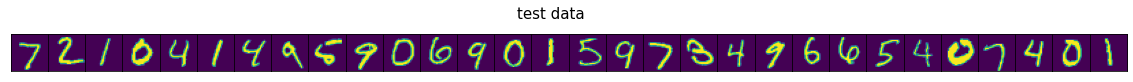

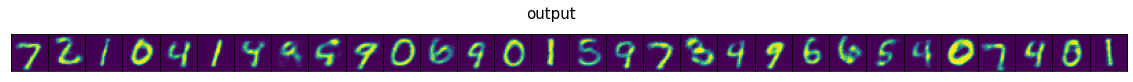

_


<Figure size 1440x144 with 0 Axes>

In [13]:
num_image = 30

fig = plt.figure(figsize=(20, 2))

n = 0
for i in range(num_image):
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(testdataset[n])
    n += 1
fig.suptitle('test data', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
n = 0
for i in range(num_image):
    x_q = testdataset[n].reshape(1, 784).float().to(device)
    x_p, _ = model(x_q, 16)
    x_p = x_p.reshape(28, 28).cpu().detach()
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(x_p.cpu().data.numpy().reshape(28, 28))
    n += 1
model.train()
fig.suptitle('output', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
print('_')

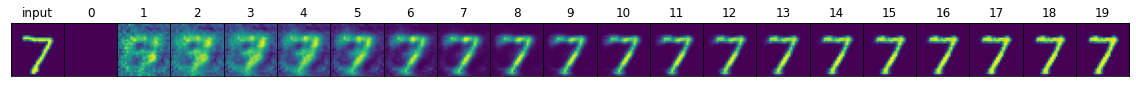

_


In [27]:
model.eval()

T = 20
x_q = testdataset[0].reshape(1, 784).float().to(device)
model.eval()
history = model.reconstruction_history(x_q, T)
n = 1

fig = plt.figure(figsize=(21, 2))

_fig = fig.add_subplot(2, T + 2,  1, xticks=[], yticks=[])
_fig.set_title('input')
_fig.imshow(x_q.cpu().numpy().reshape(28, 28))
for x_t in history:
    _fig = fig.add_subplot(2, T + 2, n + 1, xticks=[], yticks=[])
    _fig.set_title(str(n-1))
    _fig.imshow(x_t.cpu().data.numpy().reshape(28, 28))
    n += 1

model.train()


plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

print('_')

In [22]:
print(len(history))

20
